In [105]:
import json
from yt_dlp import YoutubeDL
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
from os import path
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torch.utils.data import sampler

# Retrieve the video links from json file
def getVideoLinks() -> list[str]:
    file_path = path.join(path.dirname(os.getcwd()), 'data/videos.json')
    with open(file_path) as f:
        data = json.load(f)
        return [video['link'] for video in data]
    

# Retrieve the downloaded file names
def getFileNames() -> list[str]:
    return os.listdir(path.join(path.dirname(os.getcwd()), 'data/dl_audios'))

In [ ]:
# Run when audios aren't downloaded - get the video links and download audios locally to data/dl_audios

URLs = getVideoLinks()

file_path = path.join(path.dirname(os.getcwd()), 'data/dl_audios')
ydl_config = {
    'format': 'm4a/bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'm4a',
    }],
    'outtmpl': path.join(file_path, '%(title)s.%(ext)s'),
}

with YoutubeDL(ydl_config) as ydl:
    error_code = ydl.download(URLs)

In [103]:
def preprocessAudio(y: np.ndarray) -> np.ndarray:
    y = librosa.to_mono(y) # set to mono
    y = y / np.abs(y).max() # normalize amplitude
    return y

# Get the log mels of the files
def getLogMels(file_names: list[str]) -> np.ndarray:
    log_mels = np.ndarray(len(file_names), dtype=np.ndarray)

    for i, fn in enumerate(file_names):
        fp = path.join(path.join(path.dirname(os.getcwd()), 'data/dl_audios'), fn)
        y, sr = librosa.load(fp, sr=sr_param)
        y = preprocessAudio(y)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_mels[i] = librosa.power_to_db(mel, ref=np.max)

    return log_mels

sr_param = 16000
file_names = getFileNames()
log_mels = getLogMels(file_names)

/var/folders/bf/ndmghq_10v1_jwytcddbsk7c0000gn/T/ipykernel_57348/196020950.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(fp, sr=sr_param)


/var/folders/bf/ndmghq_10v1_jwytcddbsk7c0000gn/T/ipykernel_57348/497997082.py:9: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/william_ong/Desktop/Projects/video-annotator/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


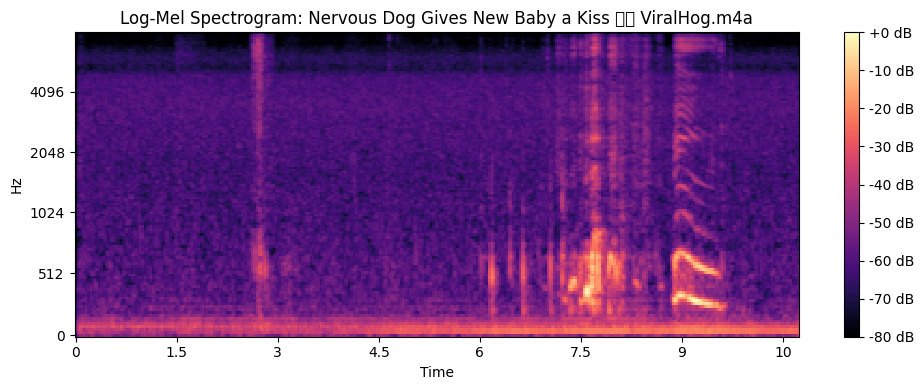

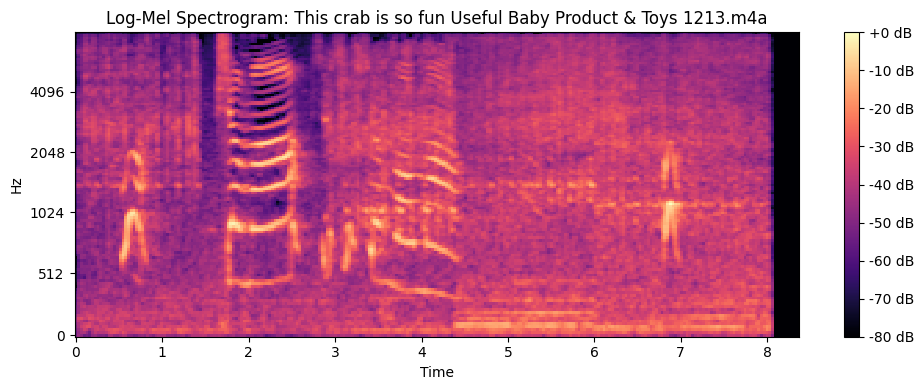

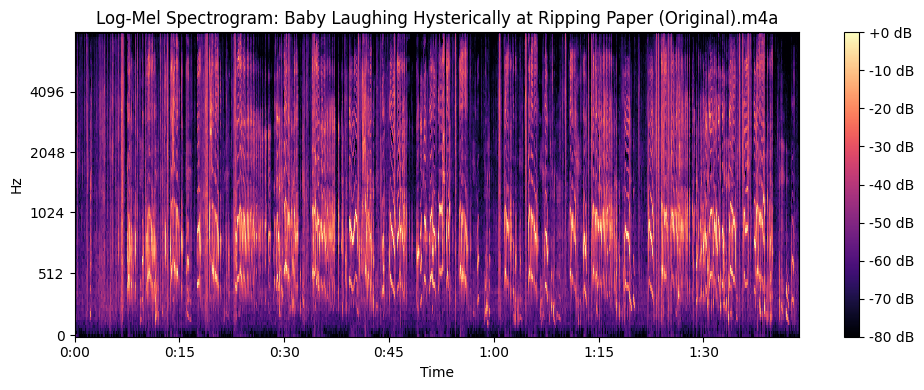

In [101]:
# Visualize first 3 log mel spectrograms

for i in range(3):
    plt.figure(figsize=(10, 4))
    # TODO - should bench mark different sample rates
    librosa.display.specshow(log_mels[i], sr=sr_param, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Log-Mel Spectrogram: {file_names[i]}')
    plt.tight_layout()
    plt.show()

In [100]:
# Load training data (clips of crying/laughing babies)

class_labels = {
    'laugh': '/t/dd00001',
    'cry': '/t/dd00002'
}

df_train = pd.read_csv(
    '../data/balanced_train_segments.csv',
    comment='#',
    header=None,
    names=['YTID', 'start_seconds', 'end_seconds', 'labels'],
    sep = r'\s+',
    engine='python',
)

df_test = pd.read_csv(
    '../data/eval_segments.csv',
    comment='#',
    header=None,
    names=['YTID', 'start_seconds', 'end_seconds', 'labels'],
    sep = r'\s+',
    engine='python',
)

laugh_train = df_train[df_train['labels'].str.contains(class_labels['laugh'])]
cry_train = df_train[df_train['labels'].str.contains(class_labels['cry'])]

laugh_test = df_test[df_test['labels'].str.contains(class_labels['laugh'])]
cry_test = df_test[df_test['labels'].str.contains(class_labels['cry'])]

laugh_data = pd.concat([laugh_train, laugh_test])
cry_data = pd.concat([cry_train, cry_test])

In [ ]:
# !! Run script in 
# Load the VGG-like extracted features from the dataset

context_features = {
    'video_id': tf.io.FixedLenFeature([], dtype=tf.string),
    'start_time_seconds': tf.io.FixedLenFeature([], dtype=tf.float32),
    'end_time_seconds': tf.io.FixedLenFeature([], dtype=tf.float32),
    'labels': tf.io.VarLenFeature(dtype=tf.int64),
}

sequence_features = {
    "audio_embedding": tf.io.FixedLenSequenceFeature([], dtype=tf.string)
}

# Parse the AudioSet sequence
def parseSquence(serialized_example):
    context, sequence = tf.io.parse_single_sequence_example(
        serialized=serialized_example,
        context_features=context_features,
        sequence_features=sequence_features
    )

    # Decode the 128-dimensional 8-bit quantized audio embedding bytes - (1, 128) vector per second
    audio_embeddings = tf.map_fn(
        lambda x: tf.io.decode_raw(x, tf.uint8),
        sequence["audio_embedding"],
        dtype=tf.uint8
    )

    return {
        "video_id": context["video_id"],
        "start_time": context["start_time_seconds"],
        "end_time": context["end_time_seconds"],
        "labels": tf.sparse.to_dense(context["labels"]),
        "audio_embedding": audio_embeddings,
    }


# Retrieve the 128-D features from the sequences - produces a list of PyTorch tensors
def getFeatures(dataset: pd.DataFrame, isTrain: bool):

    features = []

    for id in dataset['YTID']:
        rd = tf.data.TFRecordDataset(f"../data/audioset_v1_embeddings/{'bal_train' if isTrain else 'eval'}/{id[:2]}.tfrecord")
        rd = rd.map(parseSquence)
        
        for sample in rd:
            vid_id = sample['video_id'].numpy().decode("utf-8")

            if vid_id == id[:len(id) - 1]:
                features.append(torch.from_numpy(sample["audio_embedding"].numpy()))
                break

    return features


# Original features
laugh_features_train = getFeatures(laugh_train, isTrain=True)
cry_features_train = getFeatures(cry_train, isTrain=True)

laugh_features_test = getFeatures(laugh_test, isTrain=False)
cry_features_test = getFeatures(cry_test, isTrain=False)


# Padded features to 10 secs
train_features = pad_sequence(laugh_features_train + cry_features_train, batch_first=True)
test_features = pad_sequence(laugh_features_test + cry_features_test, batch_first=True)

train_labels = [0] * len(laugh_features_train) + [1] * len(cry_features_train)
test_labels = [0] * len(laugh_features_test) + [1] * len(cry_features_test)

In [126]:
# VGGish classification model - input a VGGish 128D feature -> output a prediction
# 0 - baby laughing, 1 - baby crying, (TODO: 2 - neither / cannot determine)


# TODO: Shuffled and sampled features w/ DataLoader

# Hyperparameters - pooling sizes? hidden layer sizes? 
lrs = [1e-2, 1e-3, 1e-4, 1e-5]


model = nn.Sequential(
  # TODO: LSTM? Norm type? Non-linearity type? Loss type? 
)


# Train

# Optimization

# Evaluation